# Project Details
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score, matthews_corrcoef, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import time
import warnings
warnings.filterwarnings('ignore')
import pickle

from sklearn import model_selection, metrics

import seaborn as sns


In [2]:
modelFolder = '/Users/vk/Desktop/SchoolAndResearch/INSIGHT/HFT/models/ORIGINAL/'

data = pd.read_csv('/Users/vk/Desktop/SchoolAndResearch/INSIGHT/HFT/data/StockTrainData.csv')

features = ['high', 'low', 'average', 'volume', 'numberOfTrades', 'open',  'close', 'momentum_roc', 
            'momentum_rsi', 'momentum_stoch', 'trend_macd']

In [3]:
data.head()


,date,label,high,low,average,volume,numberOfTrades,open,close,stock,momentum_roc,momentum_rsi,momentum_stoch,trend_aroon_ind,trend_macd,trend_macd_signal,trend_macd_diff
0,2020-08-03 09:30:00,09:30 AM,40.61,40.585,40.600,200,4,40.585,40.61,WBA,0.0,100.00000,65.11628,0.0,0.00000,0.00000,0.00000
1,2020-08-03 09:31:00,09:31 AM,40.41,40.370,40.390,200,2,40.410,40.37,WBA,0.0,0.00000,10.71429,-4.0,-0.01994,-0.00399,-0.01595
2,2020-08-03 09:32:00,09:32 AM,NaN,NaN,NaN,0,0,NaN,NaN,WBA,0.0,0.00000,30.27523,-8.0,-0.03973,-0.01114,-0.02859
3,2020-08-03 09:33:00,09:33 AM,40.30,40.280,40.293,300,2,40.300,40.28,WBA,0.0,31.91767,53.21101,-8.0,-0.04480,-0.01787,-0.02693
4,2020-08-03 09:34:00,09:34 AM,NaN,NaN,NaN,0,0,NaN,NaN,WBA,0.0,23.04564,27.52294,-16.0,-0.05944,-0.02618,-0.03326


In [4]:



# Separating out the features
rollingData = data.filter(features)

rollingData = rollingData.fillna(method='ffill')
rollingDataDiff = rollingData.pct_change()

rollingDataDiff.replace([np.inf, -np.inf, np.nan], 0.000001,inplace=True)

rollingData.head(2)

,high,low,average,volume,numberOfTrades,open,close,momentum_roc,momentum_rsi,momentum_stoch,trend_macd
0,40.61,40.585,40.60,200,4,40.585,40.61,0.0,100.0,65.11628,0.00000
1,40.41,40.370,40.39,200,2,40.410,40.37,0.0,0.0,10.71429,-0.01994


In [5]:
dff = rollingDataDiff.head(2)
dff.tail(1)

,high,low,average,volume,numberOfTrades,open,close,momentum_roc,momentum_rsi,momentum_stoch,trend_macd
1,-0.004925,-0.005298,-0.005172,0.0,-0.5,-0.004312,-0.00591,0.000001,-1.0,-0.835459,0.000001


# Get Data


In [6]:

#  if no trades prior minute, fill with previous row on all columns except volume/number of trades




tr_close = rollingDataDiff['close']
tr_direction = (tr_close > tr_close.shift()).astype(int)
rollingDataDiff['target'] = tr_direction.shift(-1).fillna(0).astype(int)




In [7]:
X = rollingDataDiff.iloc[:,:-1]
y = rollingDataDiff['target']

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.70,test_size=0.30, random_state=21)



In [ ]:
graphDict = dict()





In [42]:
def findMetrics(modelName, yTest, yPredicted):
    
    metricsDF = dict()
    
    accuracy = round(accuracy_score(yTest, yPredicted),2)
    precision = round(average_precision_score(yTest, yPredicted),2)
    recall = round(recall_score(yTest, yPredicted),2)
    
    tn, fp, fn, tp = confusion_matrix(yTest, yPredicted).ravel()
    specificity = round(tn / (tn+fp), 2)
    sensitivity = round(tp / (tn+fp), 2)
    
    aucRocScore = round(roc_auc_score(yTest, yPredicted),2)
    f1Score = round(f1_score(yTest, yPredicted),2)
    
    mcc = round(matthews_corrcoef(yTest, yPredicted),2)
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  yPredicted)
    
    
    metricsDF['model_name'] = modelName
    metricsDF['precision'] = precision
    metricsDF['accuracy'] = accuracy
    metricsDF['recall'] = recall
    metricsDF['specificity'] = specificity
    metricsDF['sensitivity'] = sensitivity
    metricsDF['aucRocScore'] = aucRocScore
    metricsDF['f1score'] = f1Score
    metricsDF['mcc'] = mcc
    #metricsDF['fpr'] = fpr
    #metricsDF['tpr'] = tpr
    
    met = pd.DataFrame.from_dict(metricsDF, orient ='index') 
    
    print (met)
    
    #  confusion matrix & AUC/ROC curve


    cm = metrics.confusion_matrix(yTest, yPredicted)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    all_sample_title = '{0}:: Precision: {1}, Accuracy: {2}'.format(model_name,precision, accuracy)
    plt.title(all_sample_title, size = 15);
    plt.show()


    
    plt.plot(fpr, tpr, color='orange', label="AUC="+str(aucRocScore))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
    

    
    return (fpr, tpr, accuracy, aucRocScore, f1Score)
    


# Create Model

## Logistic Regression

                              0
model_name   LogisticRegression
precision                  0.52
accuracy                   0.62
recall                     0.37
specificity                0.83
sensitivity                0.31
aucRocScore                 0.6
f1score                    0.47
mcc                        0.23


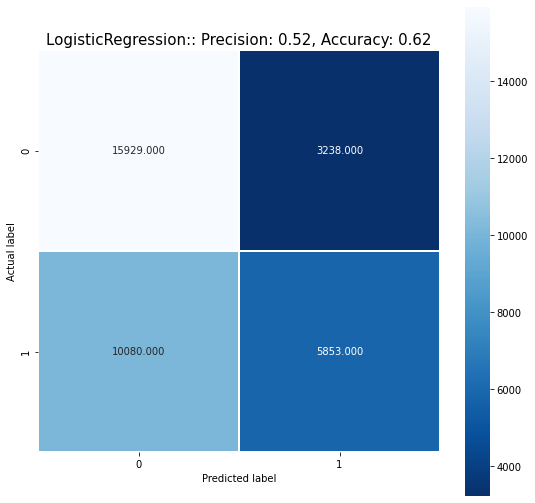

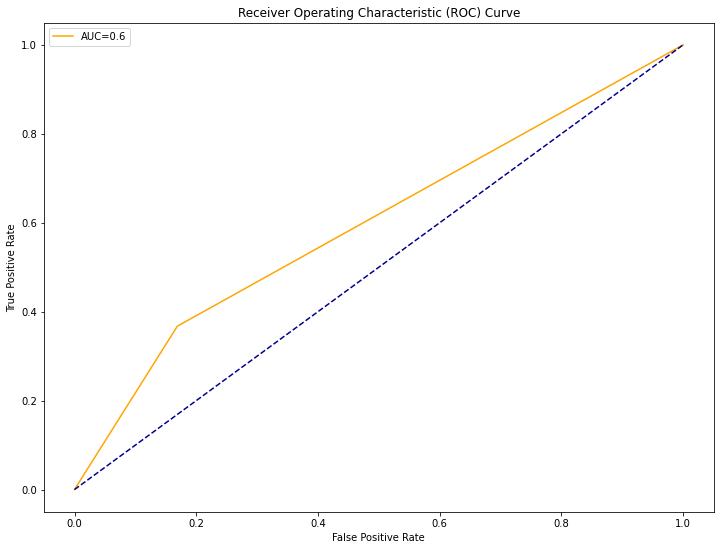

In [43]:



from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logit = logisticRegr.fit(x_train, y_train)

# save the model
model_name = 'LogisticRegression'
model_file = str(modelFolder) + str(model_name) + '.pkl'
pickle.dump(logit, open(model_file, 'wb'))

predictions = logisticRegr.predict(x_test)

fpr, tpr, accScore, aucRocScore, f1Score = findMetrics(model_name, y_test, predictions)










# Random Forest

                        0
model_name   RandomForest
precision            0.68
accuracy             0.77
recall               0.72
specificity          0.82
sensitivity           0.6
aucRocScore          0.77
f1score              0.74
mcc                  0.54


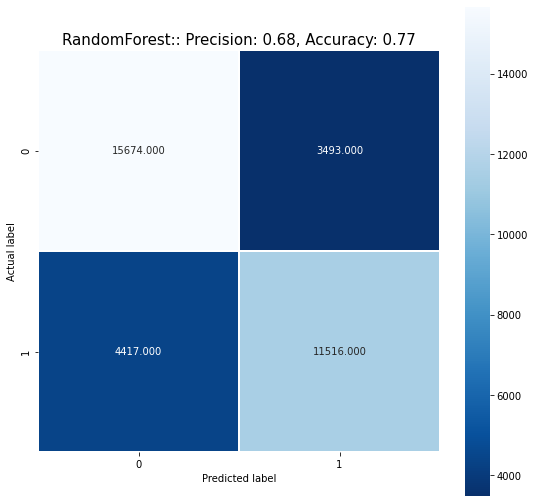

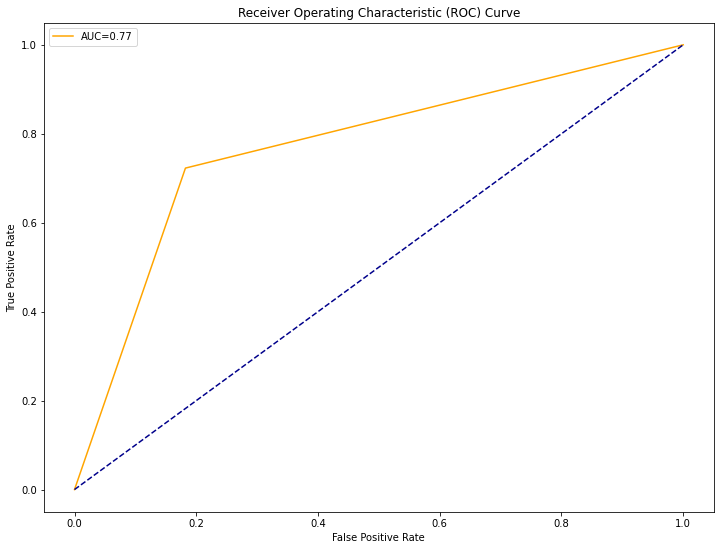

In [44]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)

randomFit = clf.fit(x_train,y_train)

randomPredictions=clf.predict(x_test)

model_name = 'RandomForest'
model_file = str(modelFolder) + str(model_name) + '.pkl'
pickle.dump(randomFit, open(model_file, 'wb'))



#  confusion matrix & AUC/ROC curve

fpr, tpr, accScore, aucRocScore, f1Score = findMetrics(model_name, y_test, randomPredictions)


# SVC 

                0
model_name    SVM
precision    0.51
accuracy     0.61
recall        0.3
specificity  0.86
sensitivity  0.25
aucRocScore  0.58
f1score      0.41
mcc          0.19


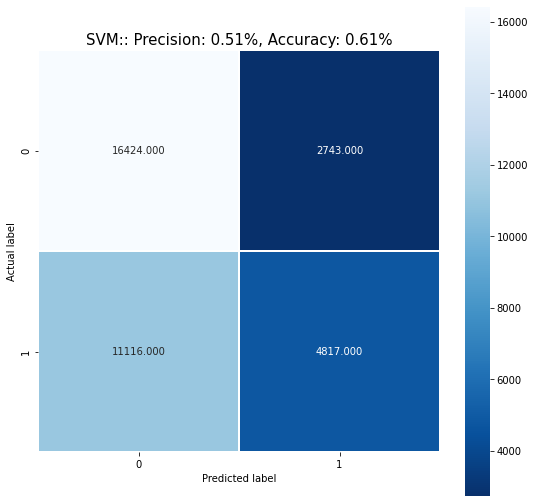

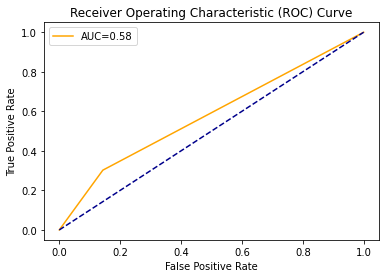

In [14]:
from sklearn import svm

model_name = 'SVM'


svmClassifier = svm.SVC()
svmFit = svmClassifier.fit(x_train, y_train)
svmPredictions = svmClassifier.predict(x_test)

model_file = str(modelFolder) + str(model_name) + '.pkl'
pickle.dump(svmFit, open(model_file, 'wb'))

fpr, tpr, accScore, aucRocScore, f1Score = findMetrics(model_name, y_test, svmPredictions)




# Naive Bayes

                      0
model_name   NaiveBayes
precision          0.45
accuracy           0.45
recall                1
specificity           0
sensitivity        0.83
aucRocScore         0.5
f1score            0.62
mcc                   0


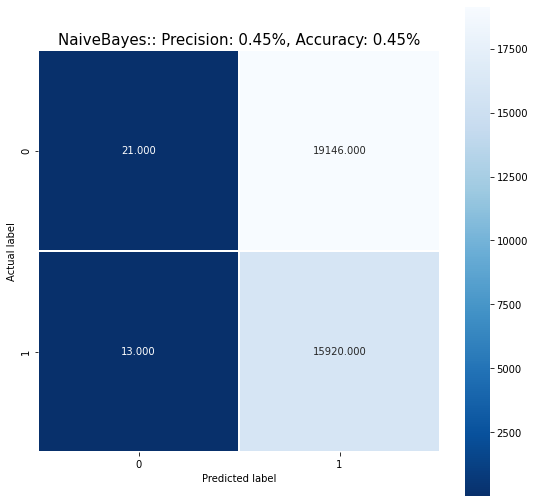

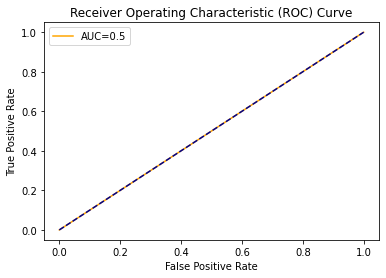

In [13]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

#Train the model using the training sets
naiveFit = gnb.fit(x_train, y_train)

#Predict the response for test dataset
naivePredictions = gnb.predict(x_test)
# load the model


model_name = 'NaiveBayes'
model_file = str(modelFolder) + str(model_name) + '.pkl'
pickle.dump(naiveFit, open(model_file, 'wb'))


#  confusion matrix & AUC/ROC curve

fpr, tpr, accScore, aucRocScore, f1Score = findMetrics(model_name,y_test, naivePredictions)








# RNN

### Calculate Model score - accuracy = total correct predictions / total predictions made * 100

In [50]:
def scores(models, X, y):

    for model in models:
        y_pred = model.predict(X)
        acc = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auc = roc_auc_score(y, y_pred)
        
        print ("------------------------")
        print ("------------------------")
        print ('')
        print (model)
        print("Accuracy Score: {0:0.2f} %".format(acc * 100))
        print("F1 Score: {0:0.4f}".format(f1))
        print("Area Under ROC Curve Score: {0:0.4f}".format(auc))
        print ('')
        print ("------------------------")
        print ("------------------------")
        
        
        
        cm = metrics.confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(9,9))
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        
        acc = 66.79
        all_sample_title = '{0}: {1} %'.format('RNN',acc)
        plt.title(all_sample_title, size = 15);
        print ("------------------------")
        
        
        

In [48]:
models = [
    MLPClassifier(random_state=5)
]

for model in models: 
    model.fit(x_train, y_train)

    

    
grid_data = [

                    # MLPClassifier - Neural Network multi layer perceptron 
                {
                #'hidden_layer_sizes': [10, 50, 100],
                'hidden_layer_sizes': [2],
                'activation': ['tanh'],
                'solver': ['adam'],
                'learning_rate': ['constant'],
                'max_iter': [400],
                'random_state': [5]
               }
        
                ]

models_grid = list()



## Train the models (in the grid)

0 {'hidden_layer_sizes': [2], 'activation': ['tanh'], 'solver': ['adam'], 'learning_rate': ['constant'], 'max_iter': [400], 'random_state': [5]}
------------------------
------------------------

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=5, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Accuracy Score: 76.45 %
F1 Score: 0.7191
Area Under ROC Curve Score: 0.7560

------------------------
------------------------
------------------------
------------------------
------------------------

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_laye

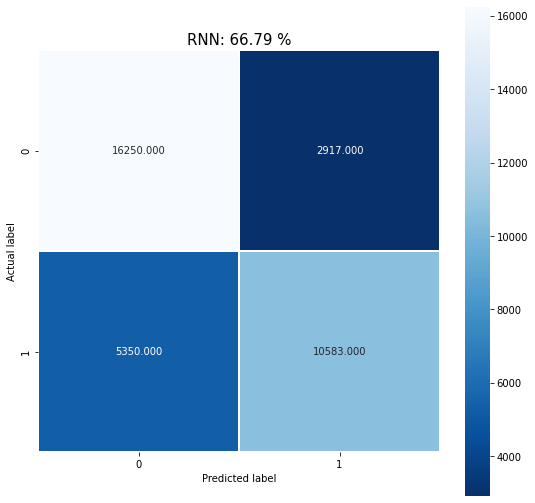

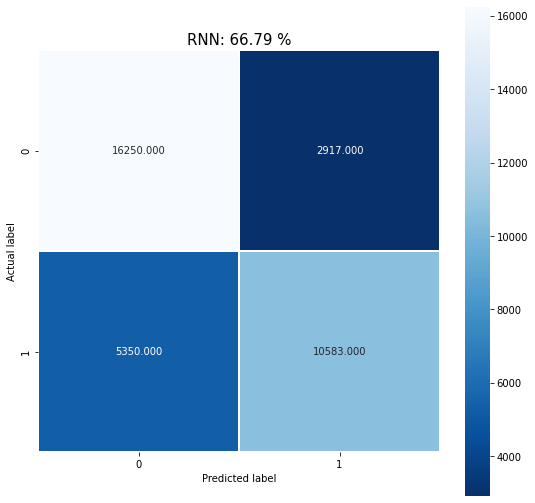

In [51]:
for i in range(1):
    print (i, grid_data[i])
    grid = GridSearchCV(models[i], grid_data[i], scoring='f1').fit(x_train, y_train)
    model = grid.best_estimator_
    models_grid.append(model)
    scores(models_grid, x_test, y_test)

### Save the models using pickle library, these model (files) will be later used for live trading

In [27]:
val = 1
model_name = 'Start'

for model in models_grid:
    model_name = 'RNN'
    print (model, model_name)
    model_file = modelFolder + str(model_name) + '.pkl'
    pickle.dump(model, open(model_file, 'wb'))


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=5, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) RNN


In [15]:
mydf = pd.read_csv("/tmp/t.csv")

In [16]:
mydf

,ModelName,Precision,Accuracy
0,Logistic Regression,0.52,0.62
1,Naive Bayes,0.45,0.45
2,SVM,0.51,0.61
3,Random Forest,0.68,0.78
4,RNN,0.65,0.76


In [22]:
mydf

,ModelName,Precision,Accuracy
0,Logistic Regression,0.52,0.62
1,Naive Bayes,0.45,0.45
2,SVM,0.51,0.61
3,Random Forest,0.68,0.78
4,RNN,0.65,0.76


In [23]:
mydf.columns

Index(['ModelName', ' Precision', ' Accuracy'], dtype='object')

In [24]:
d = {'class': ['first', 'second', 'third', 'first', 'second', 'third', 'first', 'second', 'third'], 'sex': ['men', 'men', 'men', 'woman', 'woman', 'woman', 'children', 'children', 'children'], 'survival_rate':[0.914680, 0.300120, 0.118990, 0.667971, 0.329380, 0.189747, 0.660562, 0.882608, 0.121259]} 

df = pd.DataFrame(data=d)

In [25]:
df.columns

Index(['class', 'sex', 'survival_rate'], dtype='object')

In [30]:
plotdata = pd.DataFrame({
    "Accuracy":[62, 45, 61, 78, 76],
    "Precision":[52, 45, 51, 68, 65],
    }, 
    index=["Logistic Regression", "Naive Bayes", "SVM", "Random Forest", "RNN"]
)

plt.rcParams["figure.figsize"] = [15, 10]
plotdata.plot(kind="bar")
plt.title("Accuracy/Precision Range across models")
#plt.xlabel("Family Member")
plt.ylabel("Percentage")

Text(0, 0.5, 'Percentage Return')

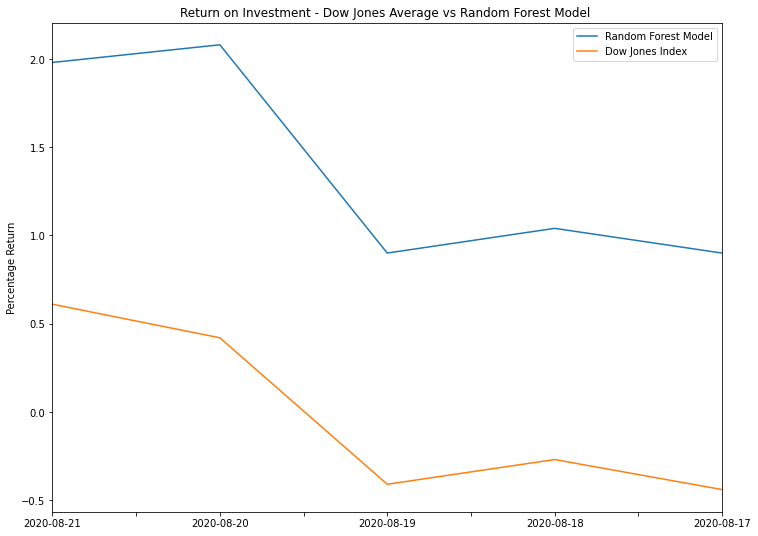

In [41]:
retData = pd.DataFrame({
    "Random Forest Model":[1.98, 2.08, 0.9, 1.04, 0.9],
    "Dow Jones Index":[0.61, 0.42, -0.41, -0.27, -0.44],
    }, 
    index=["2020-08-21", "2020-08-20", "2020-08-19", "2020-08-18", "2020-08-17"]
)

plt.rcParams["figure.figsize"] = [12, 9]
retData.plot(kind="line")
plt.title("Return on Investment - Dow Jones Average vs Random Forest Model ")
#plt.xlabel("Family Member")
plt.ylabel("Percentage Return")